# Homework 7

## 1 Data set

In [66]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [67]:
# Load the data
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# Create a tensorflow dataset from the numpy arrays
training_dataset_images = tf.data.Dataset.from_tensor_slices(training_images)
training_dataset_labels = tf.data.Dataset.from_tensor_slices(training_labels)
test_dataset_images = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset_labels = tf.data.Dataset.from_tensor_slices(test_labels)

# Expand by 1 dimension since our data is only 28x28 but we need an additional channel dimension for convolution
training_dataset_images = training_dataset_images.map(lambda img : tf.expand_dims(img, -1))
test_dataset_images = test_dataset_images.map(lambda img : tf.expand_dims(img, -1))

# Normalize the images to a range of (0,1)
training_dataset_images = training_dataset_images.map(lambda img: img/255)
test_dataset_images = test_dataset_images.map(lambda img: img/255)

# Zip the images and the labels together into one dataset
training_dataset = tf.data.Dataset.zip((training_dataset_images, training_dataset_labels))
test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_labels))

# 64 does not seem to work with later use
batch_size = 50

# batch, shuffle and prefetch
training_dataset = training_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)
test_dataset = test_dataset.batch(batch_size).shuffle(buffer_size = batch_size).prefetch(128)

## 2 Model

In [68]:
# Subclass of the Model to create an Encoder
class Encoder(tf.keras.layers.Layer):

  def __init__(self):
    super(Encoder,self).__init__()
    # Convolutioanl layers with a stride of 2 to do subsampling
    self.conv1 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 3,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',  
                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                         bias_initializer = 'zeros',                               
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01),      
                                         input_shape = (28, 28, 1))
    self.batchnorm1 = tf.keras.layers.BatchNormalization()                                     
    self.activ1 = tf.keras.activations.relu    
    self.conv2 = tf.keras.layers.Conv2D(filters = 64,
                                         kernel_size = 3,
                                         strides = 2,
                                         activation = None,
                                         padding = 'same',         
                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                         bias_initializer = 'zeros',                               
                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))     
    self.batchnorm2 = tf.keras.layers.BatchNormalization()                                     
    self.activ2 = tf.keras.activations.relu    
    self.flattenlayer = tf.keras.layers.Flatten()
    self.outputlayer = tf.keras.layers.Dense(10, activation = None)

  @tf.function
  def call(self,x,training = True):
    x = self.conv1(x)
    x = self.batchnorm1(x, training)
    x = self.activ1(x)
    x = self.conv2(x)
    x = self.batchnorm2(x, training)
    x = self.activ2(x)
    x = self.flattenlayer(x)
    x = self.outputlayer(x)
    return x

In [69]:
# Subclass of the Model to create a Decoder
class Decoder(tf.keras.layers.Layer): 
  
  def __init__(self):
    super(Decoder, self).__init__()
    # Since output of Encoder is 7x7
    self.inputlayer = tf.keras.layers.Dense(49)
    # Transposed convolution to perform upsampling from 7x7 back to 28x28
    self.transpconv1 = tf.keras.layers.Conv2DTranspose(filters = 64,
                                                         kernel_size = 3,
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',
                                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                                         bias_initializer = 'zeros',                               
                                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))
    self.batchnorm1 = tf.keras.layers.BatchNormalization()                                     
    self.activ1 = tf.keras.activations.relu    
    self.transpconv2 = tf.keras.layers.Conv2DTranspose(filters = 64,
                                                         kernel_size = 3,
                                                         strides = 2,
                                                         activation = None,
                                                         padding = 'same',         
                                                         kernel_initializer = tf.keras.initializers.glorot_normal,  
                                                         bias_initializer = 'zeros',                               
                                                         kernel_regularizer = tf.keras.regularizers.L2(0.01))    
    self.batchnorm2 = tf.keras.layers.BatchNormalization()                         
    self.outputlayer = tf.keras.layers.Conv2D(filters = 1,
                                               kernel_size = 3,
                                               strides = 1,
                                               activation = tf.keras.activations.sigmoid,
                                               padding = 'same')

  @tf.function
  def call(self,x,training=True):
    x = self.inputlayer(x)
    # Reshape into correct size since Encoder flattened the image
    x = tf.reshape(x, [-1, 7, 7, 1])
    x = self.transpconv1(x)
    x = self.batchnorm1(x, training)
    x = self.activ1(x)
    x = self.transpconv2(x)
    x = self.batchnorm2(x, training)
    x = self.outputlayer(x)
    return x

In [70]:
class Autoencoder(tf.keras.Model): 
  def __init__(self):
    super(Autoencoder, self).__init__()
    # Add the Encoder and the Decoder
    self.encoder = Encoder()
    self.decoder = Decoder()

  def call(self,x,training=True,interpolate=False):
    if interpolate == False:
      embeddings = self.encoder(x)
      output = self.decoder(embeddings)
      return output, embeddings  

    # Interpolate between two neighboring embeddings
    elif interpolate == True:
      embeddings = self.encoder(x)
      interpolated_embeddings = np.zeros([50, 10])
      # Skip the last one to avoid index out of bounds
      for embed in range(batch_size - 1):                                                           
        interpolated_embeddings[embed] = np.float32(embeddings[embed + 1] - embeddings[embed])
      # Get the interpolation of the last embedding by interpolating it with the first embedding instead
      interpolated_embeddings[49] = embeddings[49] - embeddings[0]                                  
      interpolated_embeddings = tf.convert_to_tensor(interpolated_embeddings, dtype= tf.float32)
      # Feed our interpolated embeddings into the encoder instead of our original embeddings
      interpolated_output = self.decoder(interpolated_embeddings)
      return interpolated_output                                                                  

## 3 Training

In [71]:
# Performs one training step on the model
def training_step(model, training_data, loss_fn, optimizer, training = True):
  training_losses = []

  for (input, target) in training_data:
    with tf.GradientTape() as tape:
      # We don't require the embeddings while training
      prediction, _ = model(input, training)                                                                                                     
      current_training_loss = loss_fn(input, prediction) + tf.math.reduce_sum(model.losses)   
      gradients = tape.gradient(current_training_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    training_losses.append(current_training_loss.numpy())

  training_loss = np.mean(training_losses)
  return training_loss
  
# Performs one test step on the model
def test(model, test_data, loss_fn, training = False, interpolate = False):
  if interpolate == False: 
    test_losses = []
    embeddings = []
    corresponding_embedding_labels = []

    test_image_counter = 0
    example_input_img = tf.zeros([28, 28, 1], tf.int32)
    example_prediction_img = tf.zeros([28, 28, 1], tf.int32)
    for (input, target) in test_data:
      # Save the embedded input of the first 1000 images for visualization
      prediction, embedded_input = model(input, training, interpolate) 
      current_test_loss = loss_fn(input, prediction)
      test_losses.append(current_test_loss.numpy()) 

      if test_image_counter < 1000:                                          
        embeddings.append(embedded_input)
        corresponding_embedding_labels.append(target)
        test_image_counter += batch_size

        # Pick one original image and one output image for visualization
        if test_image_counter == 1000:                                         
          example_input_img = input[batch_size - 1]
          example_prediction_img = prediction[batch_size - 1]
    
    test_loss = np.mean(test_losses)
    return test_loss, example_input_img, example_prediction_img, embeddings, corresponding_embedding_labels

  # If we require the interpolation image
  elif interpolate == True:
    example_interpolated_prediction_img = tf.zeros([28, 28, 1], tf.int32)

    for (input, target) in test_data:
      prediction = model(input, training, interpolate) 
      example_prediction_img = prediction[batch_size - 1]
      return example_prediction_img

Epoch 0
Example image with its reconstructed counterpart: 


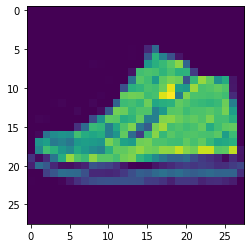

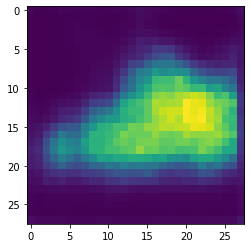

Embedded data points of the first 1000 images colored according to their class: 


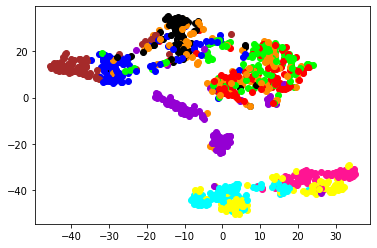

Training loss: 0.06690655
Test loss: 0.030212574
Interpolated example: 


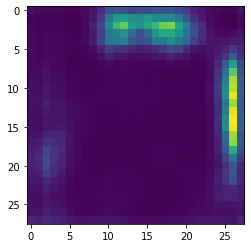

Epoch 1
Example image with its reconstructed counterpart: 


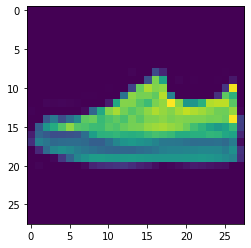

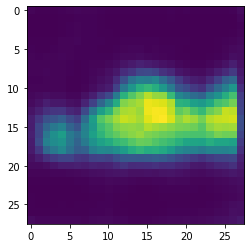

Embedded data points of the first 1000 images colored according to their class: 


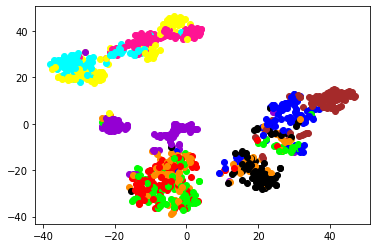

Training loss: 0.028340317
Test loss: 0.028158361
Interpolated example: 


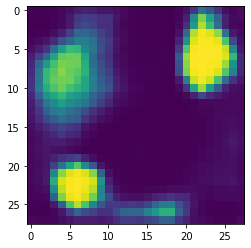

Epoch 2
Example image with its reconstructed counterpart: 


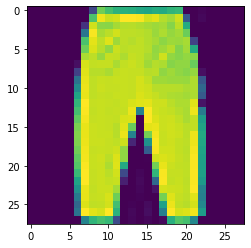

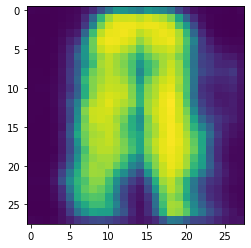

Embedded data points of the first 1000 images colored according to their class: 


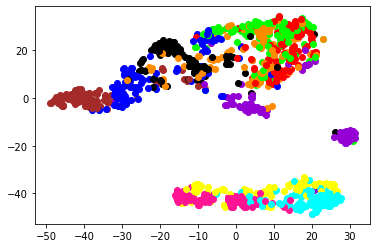

Training loss: 0.02724074
Test loss: 0.029258542
Interpolated example: 


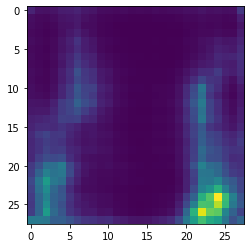

Epoch 3
Example image with its reconstructed counterpart: 


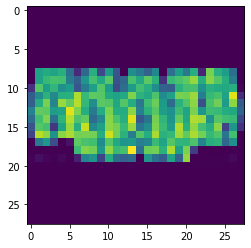

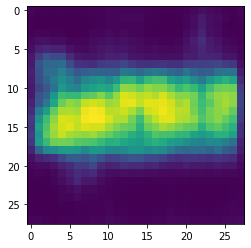

Embedded data points of the first 1000 images colored according to their class: 


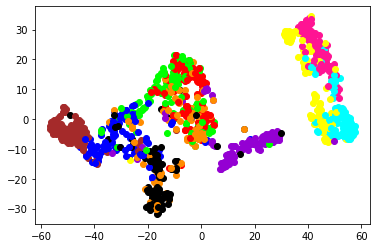

Training loss: 0.02665718
Test loss: 0.025775729
Interpolated example: 


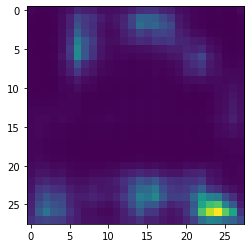

Epoch 4
Example image with its reconstructed counterpart: 


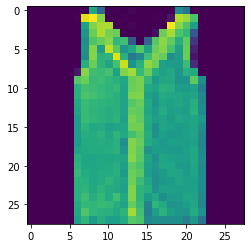

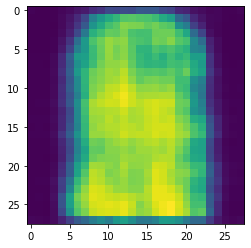

Embedded data points of the first 1000 images colored according to their class: 


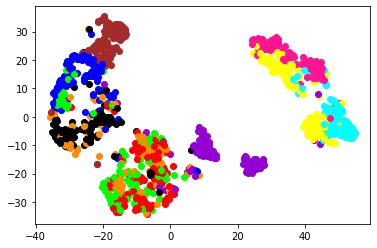

Training loss: 0.026262965
Test loss: 0.03000174
Interpolated example: 


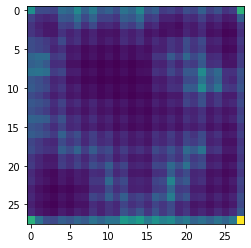

Epoch 5
Example image with its reconstructed counterpart: 


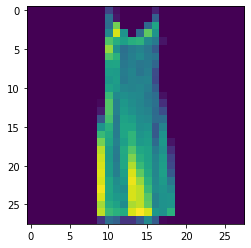

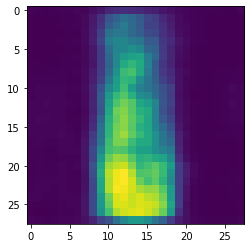

Embedded data points of the first 1000 images colored according to their class: 


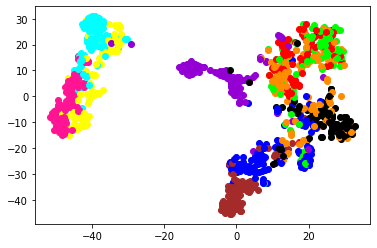

Training loss: 0.026113484
Test loss: 0.0242981
Interpolated example: 


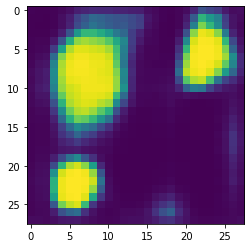

Epoch 6
Example image with its reconstructed counterpart: 


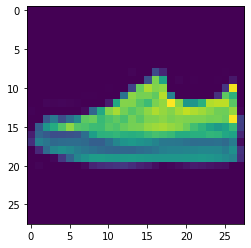

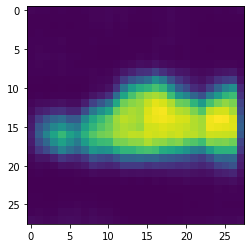

Embedded data points of the first 1000 images colored according to their class: 


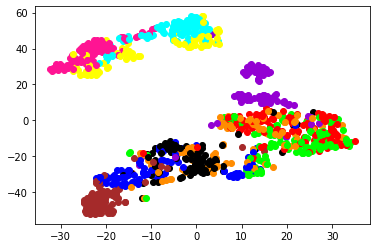

Training loss: 0.025797313
Test loss: 0.02534738
Interpolated example: 


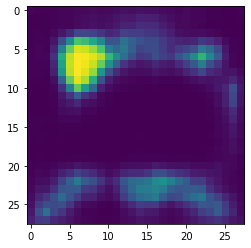

Epoch 7
Example image with its reconstructed counterpart: 


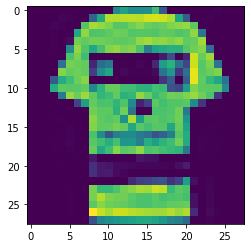

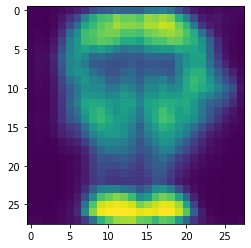

Embedded data points of the first 1000 images colored according to their class: 


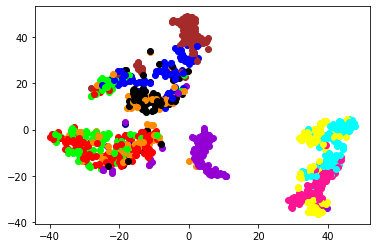

Training loss: 0.025548441
Test loss: 0.024271352
Interpolated example: 


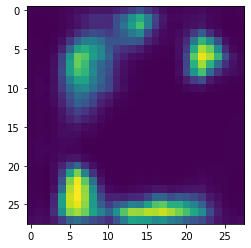

Epoch 8
Example image with its reconstructed counterpart: 


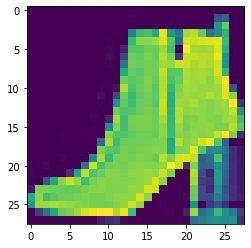

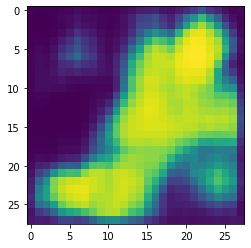

Embedded data points of the first 1000 images colored according to their class: 


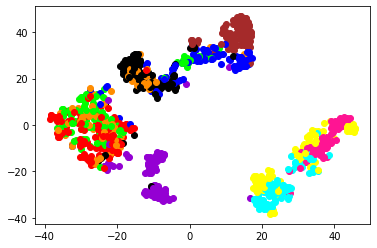

Training loss: 0.025570508
Test loss: 0.027509162
Interpolated example: 


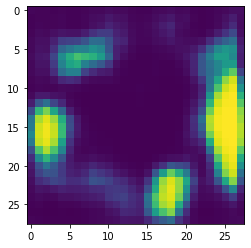

Epoch 9
Example image with its reconstructed counterpart: 


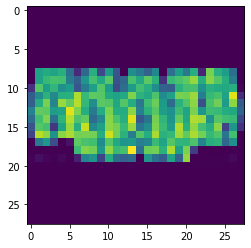

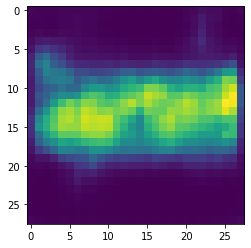

Embedded data points of the first 1000 images colored according to their class: 


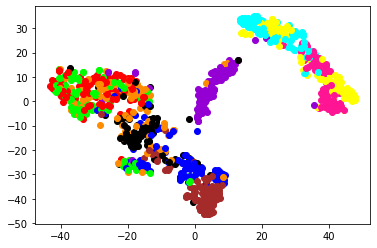

Training loss: 0.025376061
Test loss: 0.031132117
Interpolated example: 


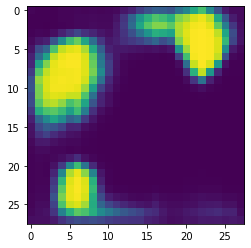

In [72]:
tf.keras.backend.clear_session()

model = Autoencoder()

n_epochs = 10
learning_rate = 0.001
loss_fn = tf.keras.losses.MeanSquaredError()                             
optimizer = tf.keras.optimizers.Adam((learning_rate), amsgrad = True)  

training_losses = []
test_losses = []

for epoch in range(n_epochs):
    print('Epoch ' + str(epoch))

    training_loss = training_step(model, training_dataset, loss_fn, optimizer, training = True)
    training_losses.append(training_loss)

    test_loss, example_input_img, example_prediction_img, embeddings, corresponding_embedding_labels = test(model, test_dataset, loss_fn, training = False, interpolate = False)                              #, test_accuracy
    test_losses.append(test_loss)

    # Reshape the embeddings since they were flattened
    embeddings = tf.reshape(embeddings, [1000, 10])
    corresponding_embedding_labels = tf.reshape(corresponding_embedding_labels, [1000])
    # Reduce the dimensionality of the embeddings to 2 for easy visualization
    reduced_embeddings = TSNE(n_components = 2).fit_transform(embeddings)

    # Example image with its reconstructed counterpart.
    print("Example image with its reconstructed counterpart: ")
    plt.imshow(tf.squeeze(example_input_img).numpy())
    plt.show()
    plt.imshow(tf.squeeze(example_prediction_img).numpy())
    plt.show()

    # Plots the embedded data points of the first 1000 images colored according to their class.
    print("Embedded data points of the first 1000 images colored according to their class: ")
    label_color_coding = ["black", "brown", "red", "blue", "lime", "yellow", "darkorange", "cyan", "darkviolet", "deeppink"]
    for embed in range(1000):
      current_label_color = label_color_coding[corresponding_embedding_labels[embed]]
      plt.scatter(reduced_embeddings[embed][0], reduced_embeddings[embed][1], color = current_label_color)
    plt.show()

    # Prints the training and test loss.
    print("Training loss: " + str(training_loss))
    print("Test loss: " + str(test_loss))

    # Interpolates linearly between the embeddings of two images and plots the reconstructed image.
    print("Interpolated example: ")
    example_interpolated_prediction_img = test(model, test_dataset, loss_fn, training = False, interpolate = True)
    plt.imshow(tf.squeeze(example_interpolated_prediction_img).numpy())
    plt.show()

## 4 Latent space analysis

The data representation shows us that our data could be more dense w.r.t. its dimensionality. This could be achieved with a Variational Autoencoder. 

Because the linear interpolation is generated based on the real images the interpolation image shows the intracategorical differences.

## Visualization

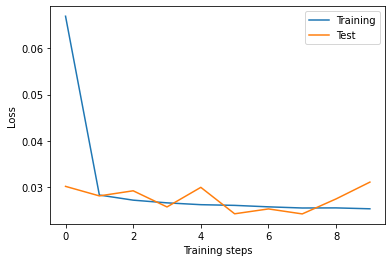

In [73]:
plt.figure()
line1, = plt.plot(training_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1, line2),("Training", "Test"))
plt.show()